In [34]:
import torch

from configs import BaseConfig

In [39]:
config = BaseConfig()
bc_trainer = torch.load(config.models_path / "bc.pt")
trainer = torch.load(config.models_path / "mi.pt")

encoders = {
    "bc": bc_trainer.encoder,
    "mi": trainer.encoder
}

In [111]:
import random
# create different action groups
action_dict = {}
action_dict['small'] = torch.rand(5_000, 3) * 0.2 - 0.1
action_dict['medium'] = (torch.rand(5_000, 3) / 10 + 0.45) * ((torch.rand(5_000, 3) > 0.5).float() * 2 - 1)
action_dict['large'] = (torch.rand(5_000, 3) / 10 + 0.9) * ((torch.rand(5_000, 3) > 0.5).float() * 2 - 1)

map_1d = torch.eye(3)[torch.randint(0, 3, (5000,))]
action_dict['1dof'] = (torch.rand(5_000, 3) * 2 - 1) * map_1d 

length = 5000
map_2d = torch.zeros(length, 3)
for i in range(length):
    indices = random.sample(range(3), 2)
    map_2d[i, indices] = 1
action_dict['2dof'] = (torch.rand(5_000, 3) * 2 - 1) * map_2d 

action_dict['3dof'] = torch.rand(5_000, 3) * 2 - 1

In [113]:
from lift.environments.simulator import SimulatorFactory
sim = SimulatorFactory.create_class(
    (config.mad_data_path / "Female0"/ "training0").as_posix(),
    config,
    return_features=True,
)

features_dict = {}
for key, actions in action_dict.items():
    features_dict[key] = sim(actions)

In [114]:
results = {}
for key, features in features_dict.items():
    results[key] = {}
    for name, encoder in encoders.items():
        with torch.no_grad():
            results[key][name] = encoder.sample(features)

In [118]:
heatmap = torch.zeros(len(action_dict), len(encoders)+1)

for i, (key, features) in enumerate(features_dict.items()):
    for j, (name, encoder) in enumerate(encoders.items()):
        heatmap[i, j] = (results[key][name] - action_dict[key]).abs().mean()

heatmap[:, -1] = heatmap[:, 0] - heatmap[:, 1]

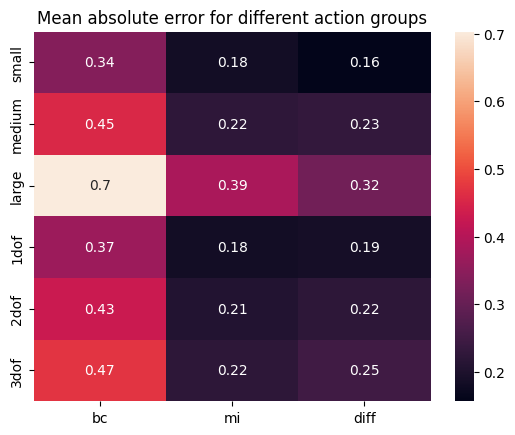

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(heatmap, annot=True, xticklabels=list(encoders.keys())+['diff'], yticklabels=action_dict.keys())
plt.title("Mean absolute error for different action groups")
plt.show()

In [127]:
gt_large_abs = (action_dict['large'].abs() > 0.9).type(torch.float32).mean()
bc_large_abs = (results['large']['bc'].abs() > 0.9).type(torch.float32).mean()
mi_large_abs = (results['large']['mi'].abs() > 0.9).type(torch.float32).mean()
print(f"GT large abs: {gt_large_abs:.2f}, BC large abs: {bc_large_abs:.2f}, MI large abs: {mi_large_abs:.2f}")

GT large abs: 1.00, BC large abs: 0.07, MI large abs: 0.07


In [120]:
action_dict['3dof'].abs().mean(), results['3dof']['bc'].abs().mean(), results['3dof']['mi'].abs().mean()

(tensor(0.4997), tensor(0.5040), tensor(0.4962))